# full chain of cross-section results - for studying the cross-section with different samples or different cut values

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline

versions:
{   'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'beam off': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'beam on': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'data date': '2018_08_16',
    'overlay date': '2018_09_22'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.051017899728 = N(POT on beam)/N(POT MC)


In [52]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/XsecCCQE/Figures/overlay_8.11/systematics/'
# Xsec_titles = [r'excluding the last $\cos\theta_\mu$ bin',r'with the last $\cos\theta_\mu$ bin']
Xsec_titles = [r'excluding last $\cos\theta_\mu$ bin',r'with last $\cos\theta_\mu$ bin']
Xsec_fnames = [r'without_last_ctu_bin',r'with_last_ctu_bin']

In [35]:
def get_phi_Xsecs(do_corr_phi_0=False, debug=0,
                  selected_beam_on=None,selected_beam_off=None,selected_overlay_concat=None,selected_CC1p=None):#{
    Xsec_dict = dict()
    for particle in ['mu','p']:#{
        observable='phi('+particle+')'
        var,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
        h = get_Xsec_1d(selected_beam_on,selected_beam_off,selected_overlay_concat,selected_CC1p
                        ,var=var,bins=bins,bin_width=bin_width
                        ,wname='P'+particle+' weight',mul=180./np.pi                            
                        ,do_corr_phi_0=do_corr_phi_0)
        Xsec_dict[observable] = h['Xsec']
        Xsec_dict[observable+' err'] = h['Xsec err']
        Xsec_dict['mc '+observable] = h['mc Xsec']
        Xsec_dict['mc '+observable+' err'] = h['mc Xsec err']
    #}
    return Xsec_dict
#}

In [36]:
def extract_Xsecs(do_corr_phi_0=True, debug=0, particle='mu',
                  selected_beam_on=None,selected_beam_off=None,
                  selected_overlay_concat=None,selected_CC1p=None,
                  extra_name=""):

    Xsec_dicts = dict()
    for iXsec,(Xsec_title,remove_ctu_bin) in enumerate(zip(Xsec_titles,[True,False])):#{
        Xsec_dict = get_Xsecs(do_corr_phi_0=do_corr_phi_0, debug=debug, particle=particle,
                                  remove_last_cos_theta_mu_bin=remove_ctu_bin,
                                  do_P=True, do_cos_theta=True, do_phi=True,
                                  selected_beam_on=selected_beam_on,selected_beam_off=selected_beam_off,
                                  selected_overlay_concat=selected_overlay_concat,selected_CC1p=selected_CC1p)
        Xsec_dicts[Xsec_title] = Xsec_dict
    #}    
    if debug: pp.pprint(Xsec_dicts)
        
    outfilename = Paths['1d Xsec'] + "P"+particle + "Xsecs_1D"+extra_name+".txt"
    with open(outfilename, 'w') as outfile:
        outfile.write(pickle.dumps(Xsec_dicts))
    print 'saved cross-sections into',outfilename

# full chain of cross-section extraction - nominal

In [37]:
def extract_Xsec_full_chain(extra_name='',deubg=0
                            ,minPEcut = minPEcut,maxdYZcut = maxdYZcut
                            ,delta_theta_12 = delta_theta_12,r_max_RdQ_CC1p = r_max_RdQ_CC1p
                            ,delta_Delta_phi = delta_Delta_phi,Pt_max = Pt_max
                            ,Chi2Proton_muCandidate_min = Chi2Proton_muCandidate_min,Chi2Proton_pCandidate_max = Chi2Proton_pCandidate_max):
    
    samples = load_mc_and_data(extra_name=extra_name
                         ,minPEcut = minPEcut,maxdYZcut = maxdYZcut
                         ,delta_theta_12 = delta_theta_12,r_max_RdQ_CC1p = r_max_RdQ_CC1p
                         ,delta_Delta_phi = delta_Delta_phi,Pt_max = Pt_max
                         ,Chi2Proton_muCandidate_min = Chi2Proton_muCandidate_min,Chi2Proton_pCandidate_max = Chi2Proton_pCandidate_max)
    selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = samples    
    print 'done loading samples...'
    if (("Pmu weight" not in selected_beam_on.columns) or ("Pp weight" not in selected_beam_on.columns)):
        print 'no Pmu weights, computing them'
        compute_eff_weights(beam_on=selected_beam_on,beam_off=selected_beam_off,
                                generated_CC1p=genie_CC1p,selected_CC1p=selected_CC1p,overlay=selected_overlay_concat,
                                delta_theta_12=delta_theta_12,
                                delta_Delta_phi=delta_Delta_phi,
                                Pt_max=Pt_max)     
        compute_eff_weights(beam_on=selected_beam_on,beam_off=selected_beam_off,
                                generated_CC1p=genie_CC1p,selected_CC1p=selected_CC1p,overlay=selected_overlay_concat,
                                delta_theta_12=delta_theta_12,
                                delta_Delta_phi=delta_Delta_phi,
                                Pt_max=Pt_max,
                                ob_1='Pp',ob_2='cos(theta(p))',ob_3='phi(p)',
                                reco_1='reco_Pp',reco_2='reco_Pp_cos_theta',reco_3='reco_Pp_phi',
                                true_1='truth_Pp',true_2='truth_Pp_cos_theta',true_3='truth_Pp_phi') 
        print 'done assiging Pmu weights and Pp weights and saving the files.'    
    else:
        print 'Pmu weights and Pp weights already exist.'

    
    # iterative process for correction around\phi~0
    if ('W(corr. phi~0)' not in selected_beam_on.columns):
        for sam in [selected_beam_on,selected_beam_off,selected_CC1p,selected_overlay_concat]: sam['W(corr. phi~0)'] = 1
        Xsec_dict = get_phi_Xsecs( do_corr_phi_0=False , debug=deubg , 
                                  selected_beam_on=selected_beam_on,selected_beam_off=selected_beam_off,selected_overlay_concat=selected_overlay_concat,selected_CC1p=selected_CC1p)
        correction, correction_arrays = dict(),dict()
        correction_arrays['mu'] = []; correction_arrays['p'] = [];
        correction['mu'] = correction['p'] = 1
        current_correction = 100
        while np.abs(current_correction-1)>0.0001:
            for particle,var in zip(['mu','p'],
                                    ['reco_Pmu_mcs_phi','reco_Pp_phi']):
                Xsec,Xsec_err = Xsec_dict['phi('+particle+')'],Xsec_dict['phi('+particle+') err']
                bins = Bins['phi('+particle+')']
                N = len(bins)-1; n = N/2
                Xsec_phi_0 = Xsec[n]
                Xsec_phi_not_0 = np.concatenate([Xsec[:n-1],Xsec[n+1:]])
                Xsec_err_phi_not_0 = np.concatenate([Xsec_err[:n-1],Xsec_err[n+1:]])
                mean_phi_not_0 = np.average(Xsec_phi_not_0 , weights=1./np.square(Xsec_err_phi_not_0))
                current_correction = mean_phi_not_0/Xsec_phi_0
                correction[particle] = correction[particle]*current_correction
                correction_arrays[particle].append( correction[particle] )            
                for sam in [selected_beam_on,selected_beam_off,selected_CC1p,selected_overlay_concat]:
                    indices_phi_0 = sam.index[(bins[n] <= 180./np.pi*sam[var]) & (180./np.pi*sam[var] < bins[n+1])].tolist()
                    sam.loc[indices_phi_0,'W(corr. phi~0)'] = sam.loc[indices_phi_0,'W(corr. phi~0)'] * current_correction
                Xsec_dict = get_phi_Xsecs( do_corr_phi_0=True , debug=deubg ,
                                          selected_beam_on=selected_beam_on,selected_beam_off=selected_beam_off,selected_overlay_concat=selected_overlay_concat,selected_CC1p=selected_CC1p)
        for particle in ['mu','p']: print 'correction for phi('+particle+')~0:',correction_arrays[particle][-1]
        save_selected_samples(selected_overlay_concat , selected_CC1p , selected_beam_on , selected_beam_off, extra_name=extra_name)
        print 'done performing iterative correction for phi~0 and saved the samples...'    
    else:
        print 'already performed correction for phi~0 and saved the samples...'    
    extract_Xsecs(debug=deubg,extra_name=extra_name,particle='mu',
                  selected_beam_on=selected_beam_on,selected_beam_off=selected_beam_off,                  
                  selected_overlay_concat=selected_overlay_concat,selected_CC1p=selected_CC1p)
    extract_Xsecs(debug=deubg,extra_name=extra_name,particle='p',
                  selected_beam_on=selected_beam_on,selected_beam_off=selected_beam_off,                  
                  selected_overlay_concat=selected_overlay_concat,selected_CC1p=selected_CC1p)    

In [39]:
versions['Overlay']='prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['beam on']='prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off']='prod_reco_optfilter_extbnb_v12_mcc8_dev'
versions['overlay date']='2018_09_22'
versions['data date']='2018_08_16'

extra_name=''
minPEcut = 150
maxdYZcut = 200
delta_theta_12 = 55
r_max_RdQ_CC1p = 0.43
delta_Delta_phi = 35
Pt_max = 0.35
Chi2Proton_muCandidate_min = 80
Chi2Proton_pCandidate_max = 30
extract_Xsec_full_chain(extra_name='',deubg=1
                            ,minPEcut = minPEcut,maxdYZcut = maxdYZcut
                            ,delta_theta_12 = delta_theta_12,r_max_RdQ_CC1p = r_max_RdQ_CC1p
                            ,delta_Delta_phi = delta_Delta_phi,Pt_max = Pt_max
                            ,Chi2Proton_muCandidate_min = Chi2Proton_muCandidate_min,Chi2Proton_pCandidate_max = Chi2Proton_pCandidate_max)

did not find selected overlay files from , so creating it...
285038 ccqe candidate pairs, 180092 in FV
74392 are 1mu-1p, 41.3%
55230 are other-pairs, 30.7%
155416 are cosmic, 86.3%
--------------------------------------------------------------
37228 are CC1p, 20.7%
I finished loading overlay samples. We have in total 285038 pairs
applied cuts to overlay
saved selected 1mu-1p to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_1mu-1p.csv
saved selected other-pairs to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_other-pairs.csv
saved selected cosmic to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_cosmic.csv
saved selected CC1p to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_r

In [24]:
def Draw_Xsecs(do_corr_phi_0=True, debug=0, particle='mu',
               do_last_ctu_bin=False,
               do_P=True, do_cos_theta=True, do_phi=True,               
               extra_name="",residuals_ylim=[-2,2],residuals_yticks=[-1,0,1],residuals_ytitle=1.05):    
    infilename = Paths['1d Xsec'] + "P"+particle + "Xsecs_1D"+extra_name+".txt"
    print "drawing cross-section from",infilename
    with open(infilename, 'rb') as infile:#{
        Xsec_dicts = pickle.load(infile)
    #}
    if debug: pp.pprint(Xsec_dicts)
    for iXsec,(Xsec_title,do_draw_Xsecs) in enumerate(zip(Xsec_titles,[True,do_last_ctu_bin])):#{
        if do_draw_Xsecs==False: continue
        fig=plt.figure(figsize=(24,8))            
        Xsec_dict = Xsec_dicts[Xsec_title]
        for i,(observable,true,ivar,do_var) in enumerate(zip(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']                                                        
                                                                 ,['truth_P'+particle,'truth_P'+particle+'_cos_theta','truth_P'+particle+'_phi']
                                                                 ,[(1,4),(2,5),(3,6)]
                                                                 ,[do_P,do_cos_theta,do_phi])):#{
            var,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)

            h = dict()
            h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']
            h['mc Xsec'],h['mc Xsec err'] = Xsec_dict['mc '+observable], Xsec_dict['mc '+observable+' err']
            ax = fig.add_subplot(3,3,ivar)
            if iXsec==0 and var=='reco_Pmu_cos_theta':
                mid=mid[:-1]; bin_width=bin_width[:-1]; bins=bins[:-1]
                h['Xsec']=h['Xsec'][:-1];h['Xsec err']=h['Xsec err'][:-1]
                h['mc Xsec']=h['mc Xsec'][:-1];h['mc Xsec err']=h['mc Xsec err'][:-1]
                
            plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',label='data')
            ax.bar( x=mid , height=2*h['mc Xsec err'], bottom=h['mc Xsec']-h['mc Xsec err'], width=bin_width, color=Colors['CC1p'],label='overlay') 

            
            set_axes(ax,'',y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$' 
                                        +(r'$\left[10^{-39} \frac{cm^{2}}{%s}\right]$'%units if units is not None 
                                          else r'$\left[10^{-39}cm^{2}\right]$'))
                         ,do_add_grid=True,remove_ticks_x=True,do_add_legend=True if 'Pmu_cos_theta' in var else False
                         ,ylim=(0,1.1*np.max(ax.get_ylim())))
            plt.title(Xsec_title, y=1.02,fontsize=25)
                    
            # residuals plot
            den, den_err = h['Xsec']-h['mc Xsec'],np.sqrt(np.square(h['Xsec err'])+np.square(h['mc Xsec err']))
            num, num_err = h['Xsec'],h['mc Xsec err']
            ratio = np.array([den[j]/(num[j] if np.abs(num[j])>0 else 1000) for j in range(len(num))])
            ax = fig.add_subplot(3,3,7+i)
            ratio_err = ratio*np.sqrt(np.square(den_err/den) + np.square(num_err/num))
            plt.errorbar(x=mid,xerr=0.5*bin_width,y=ratio,yerr=ratio_err,fmt='o',markersize=0,color='black')
            chi2,ndf = chi2_two_data_curves(h1=h['Xsec'],h1err=h['Xsec err'],h2=h['mc Xsec'],h2err=h['mc Xsec err'],bins=bins,debug=0)
            set_axes(ax,xlabel,y_label=r'(data-mc)/data',do_add_grid=True,ylim=residuals_ylim,yticks=residuals_yticks)
            plt.plot([np.min(bins),np.max(bins)],[0,0],'--',color='royalblue')
            plt.title(r'$\chi^2/ndf=%.2f/%d$'%(chi2,ndf), fontsize=20,y=residuals_ytitle)
        #}     
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.05)
    #} 

drawing cross-section from /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/1d_Xsec/PpXsecs_1D.txt


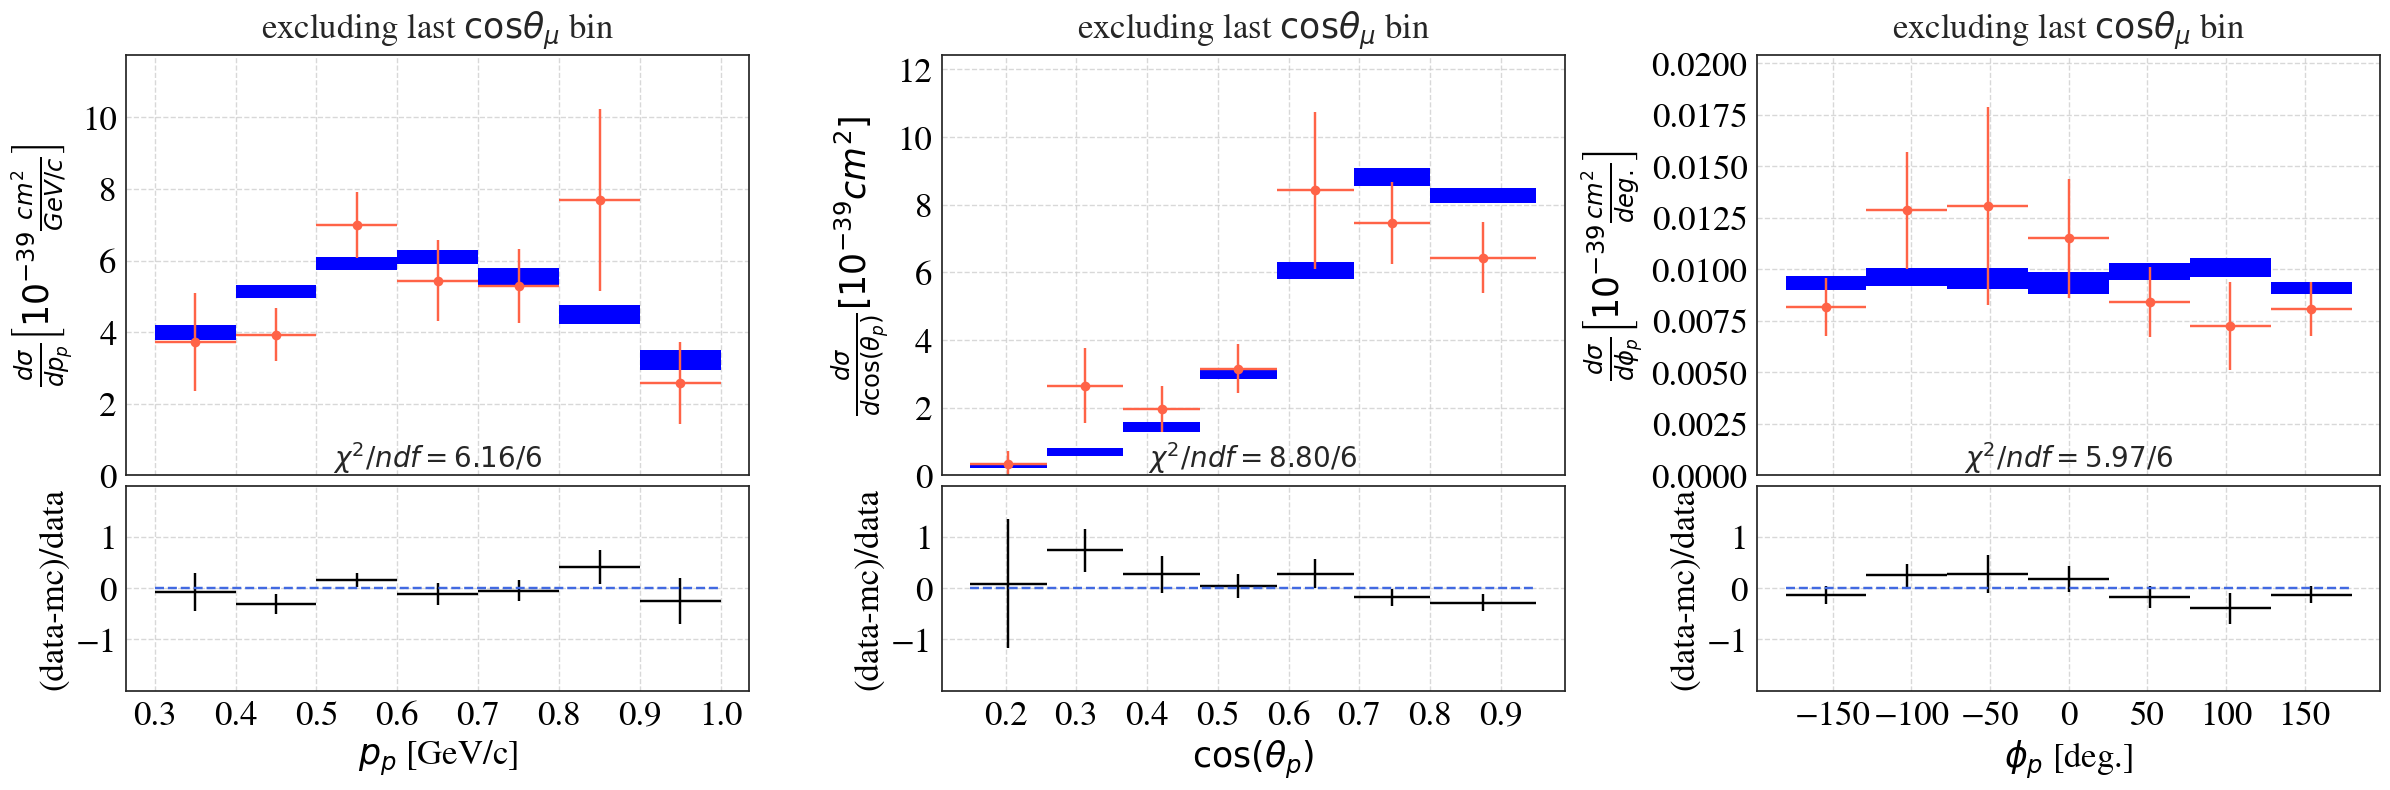

In [25]:
# CONTNIUE HERE ! (1) CHECK IF CAN DRAW PROTON AND MUON, (2) RUN ON MULTIPLE TIMES
# Draw_Xsecs(particle='mu',debug=0)
Draw_Xsecs(particle='p',debug=0)
# irand = 3
# Draw_Xsecs(particle='p',extra_name='VaryAllCuts_%d'%irand)

# extract the cross-sections for different cut-parameter values

In [27]:
Nrand = 100

for irand in range(Nrand):
    if irand%(Nrand/10)==0: print '%.1f'%(100.*float(irand)/Nrand)+'%'
    Chi2Proton_muCandidate_min = np.random.normal( 80 , 10)
    Chi2Proton_pCandidate_max = np.random.normal( 30 , 5)
    minPEcut = np.random.normal( 150 , 20)
    maxdYZcut = np.random.normal( 200 , 50)
    delta_theta_12 = np.random.normal( 55 , 5 )
    r_max_RdQ_CC1p0pi = np.random.normal( 0.43 , 0.05 )
    delta_Delta_phi = np.random.normal( 35 , 5 )
    Pt_max = np.random.normal( 0.35 , 0.05 )
    print 'Chi2Proton_muCandidate_min,Chi2Proton_pCandidate_max:',Chi2Proton_muCandidate_min,Chi2Proton_pCandidate_max
    extract_Xsec_full_chain(extra_name='VaryAllCuts_%d'%irand,deubg=0
                                ,minPEcut = minPEcut,maxdYZcut = maxdYZcut
                                ,delta_theta_12 = delta_theta_12,r_max_RdQ_CC1p = r_max_RdQ_CC1p
                                ,delta_Delta_phi = delta_Delta_phi,Pt_max = Pt_max
                                ,Chi2Proton_muCandidate_min = Chi2Proton_muCandidate_min,Chi2Proton_pCandidate_max = Chi2Proton_pCandidate_max)
    print_line();print_line()

0.0%
Chi2Proton_muCandidate_min,Chi2Proton_pCandidate_max: 87.521526808 28.8155213794
found selected overlay files from VaryAllCuts_0, loading them...
8789 selected CC1p events overlay
found selected on beam events...
found selected genie CC1p...
done loading samples...
no Pmu weights, computing them
done.
done.
done assiging Pmu weights and Pp weights and saving the files.
correction for phi(mu)~0: 3.62922497615
correction for phi(p)~0: 1.7445672896
saved  11231 selected overlay events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_VaryAllCuts_0selected_overlayVaryAllCuts_0.csv
saved  8789 selected CC1p events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_VaryAllCuts_0selected_CC1pVaryAllCuts_0.csv
saved  434 selected beam_on events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prod_reco_optfilter_bnb_v12_

# compute the mean and standard deviations of the cross-sections with different cut parameter values

In [45]:
varying_Xsec = dict()
mean_varying_Xsec,std_varying_Xsec = dict(), dict()

for particle in ['mu','p']:
    varying_Xsec[particle] = dict()
    mean_varying_Xsec[particle] = dict()
    std_varying_Xsec[particle] = dict()

    for iXsec,Xsec_title in enumerate(Xsec_titles):#{
        varying_Xsec[particle][Xsec_title] = dict()
        mean_varying_Xsec[particle][Xsec_title] = dict()
        std_varying_Xsec[particle][Xsec_title] = dict()
        for i,observable in enumerate(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']):#{
            var,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            if iXsec==0 and var=='reco_Pmu_cos_theta': bins=bins[:-1]        
            varying_Xsec[particle][Xsec_title][var] = dict()
            mean_varying_Xsec[particle][Xsec_title][var] = dict()
            std_varying_Xsec[particle][Xsec_title][var] = dict()
            for j_bin in range(len(bins)-1):#{
                varying_Xsec[particle][Xsec_title][var][j_bin] = []
            #}
        #}
    #}
    for irand in range(Nrand):
        extra_name='VaryAllCuts_%d'%irand
        infilename = Paths['1d Xsec'] + "P"+particle + "Xsecs_1D"+extra_name+".txt"
#         print "grabbing cross-section from",infilename
        with open(infilename, 'rb') as infile:#{
            Xsec_dicts = pickle.load(infile)
        #}
        for iXsec,Xsec_title in enumerate(Xsec_titles):#{
            Xsec_dict = Xsec_dicts[Xsec_title]
            for i,observable in enumerate(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']):#{
                var,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
                h = dict()
                h['Xsec'] = Xsec_dict[observable]
                h['mc Xsec'] = Xsec_dict['mc '+observable]
                if iXsec==0 and var=='reco_Pmu_cos_theta':
                    bins=bins[:-1];h['Xsec']=h['Xsec'][:-1];h['mc Xsec']=h['mc Xsec'][:-1];
                for j_bin in range(len(bins)-1):
                    varying_Xsec[particle][Xsec_title][var][j_bin].append(h['Xsec'][j_bin])
                #}
            #}
        #}
    #}
    for iXsec,Xsec_title in enumerate(Xsec_titles):#{
        for i,observable in enumerate(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']):#{
            var,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            if iXsec==0 and var=='reco_Pmu_cos_theta': bins=bins[:-1]        
            for j_bin in range(len(bins)-1):
                mean_varying_Xsec[particle][Xsec_title][var][j_bin] = np.mean(varying_Xsec[particle][Xsec_title][var][j_bin])
                std_varying_Xsec[particle][Xsec_title][var][j_bin] = np.std(varying_Xsec[particle][Xsec_title][var][j_bin])
    print 'done',particle

done mu
done p


saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/XsecCCQE/Figures/overlay_8.11/systematics/cut_sensitivty_mu_without_last_ctu_bin.pdf
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/XsecCCQE/Figures/overlay_8.11/systematics/cut_sensitivty_mu_with_last_ctu_bin.pdf
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/XsecCCQE/Figures/overlay_8.11/systematics/cut_sensitivty_p_without_last_ctu_bin.pdf
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/XsecCCQE/Figures/overlay_8.11/systematics/cut_sensitivty_p_with_last_ctu_bin.pdf


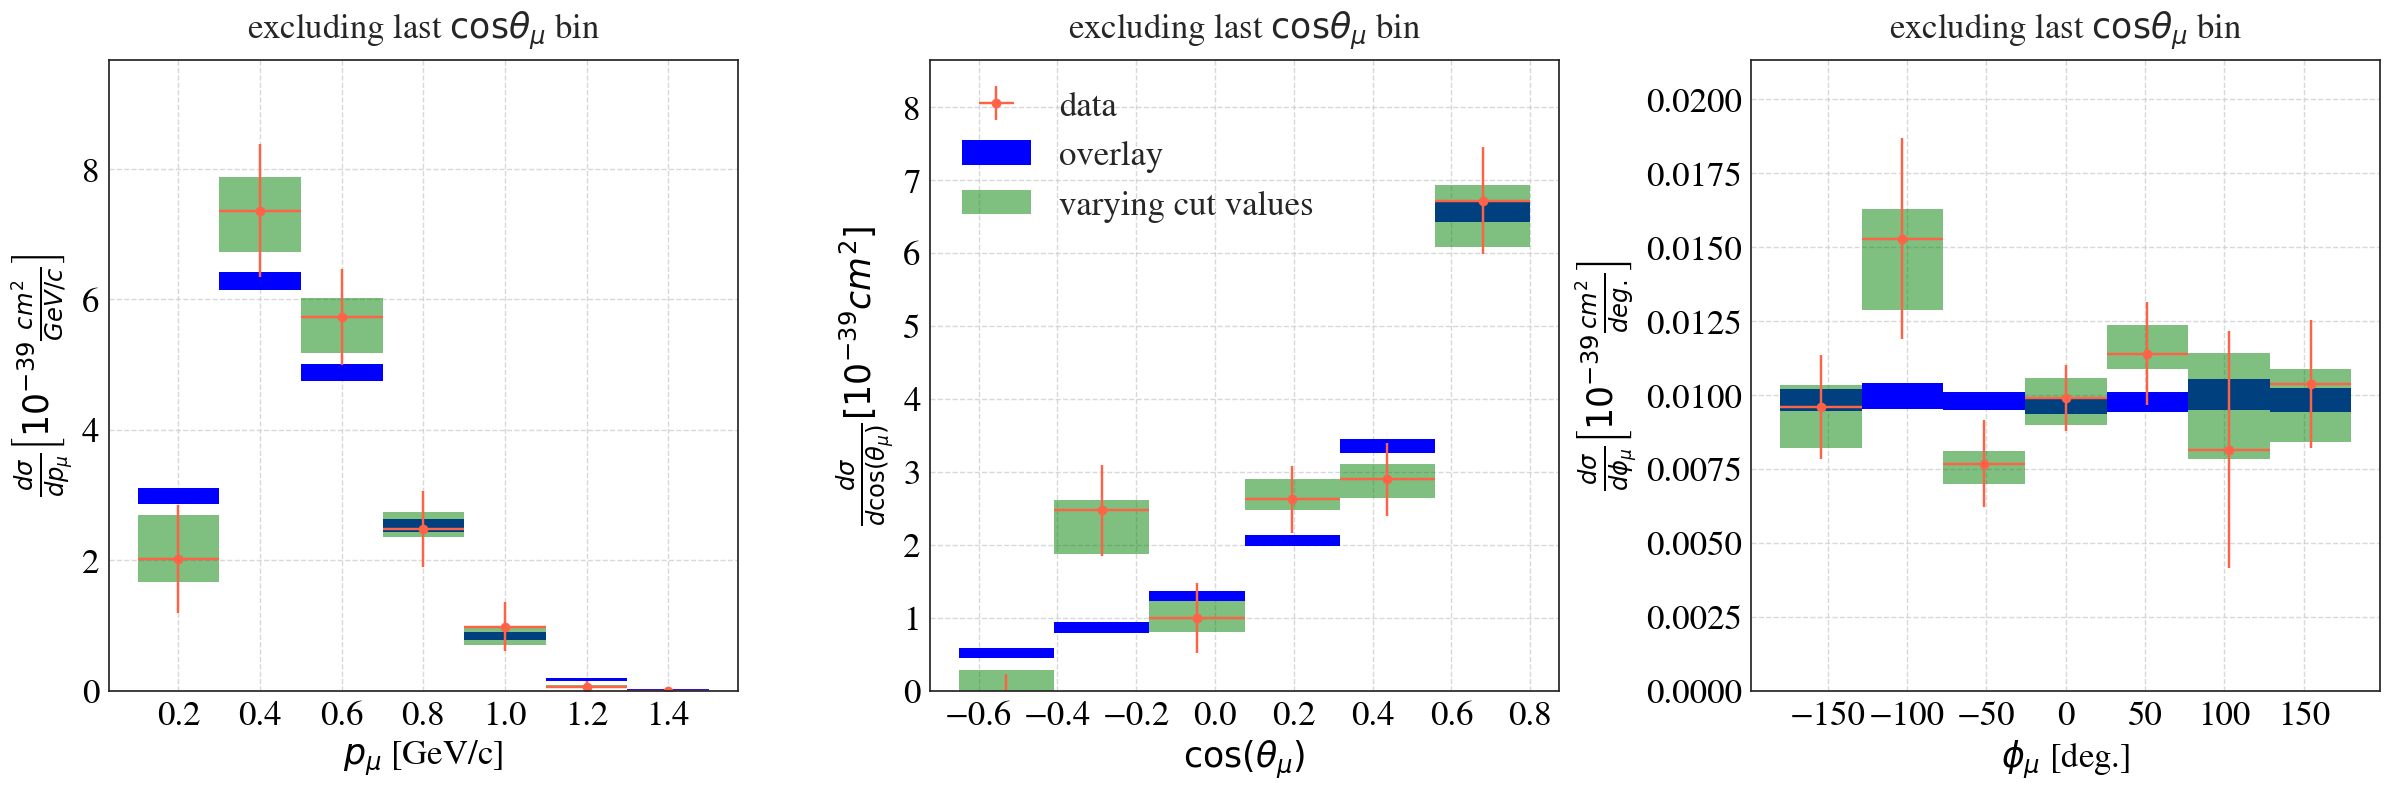

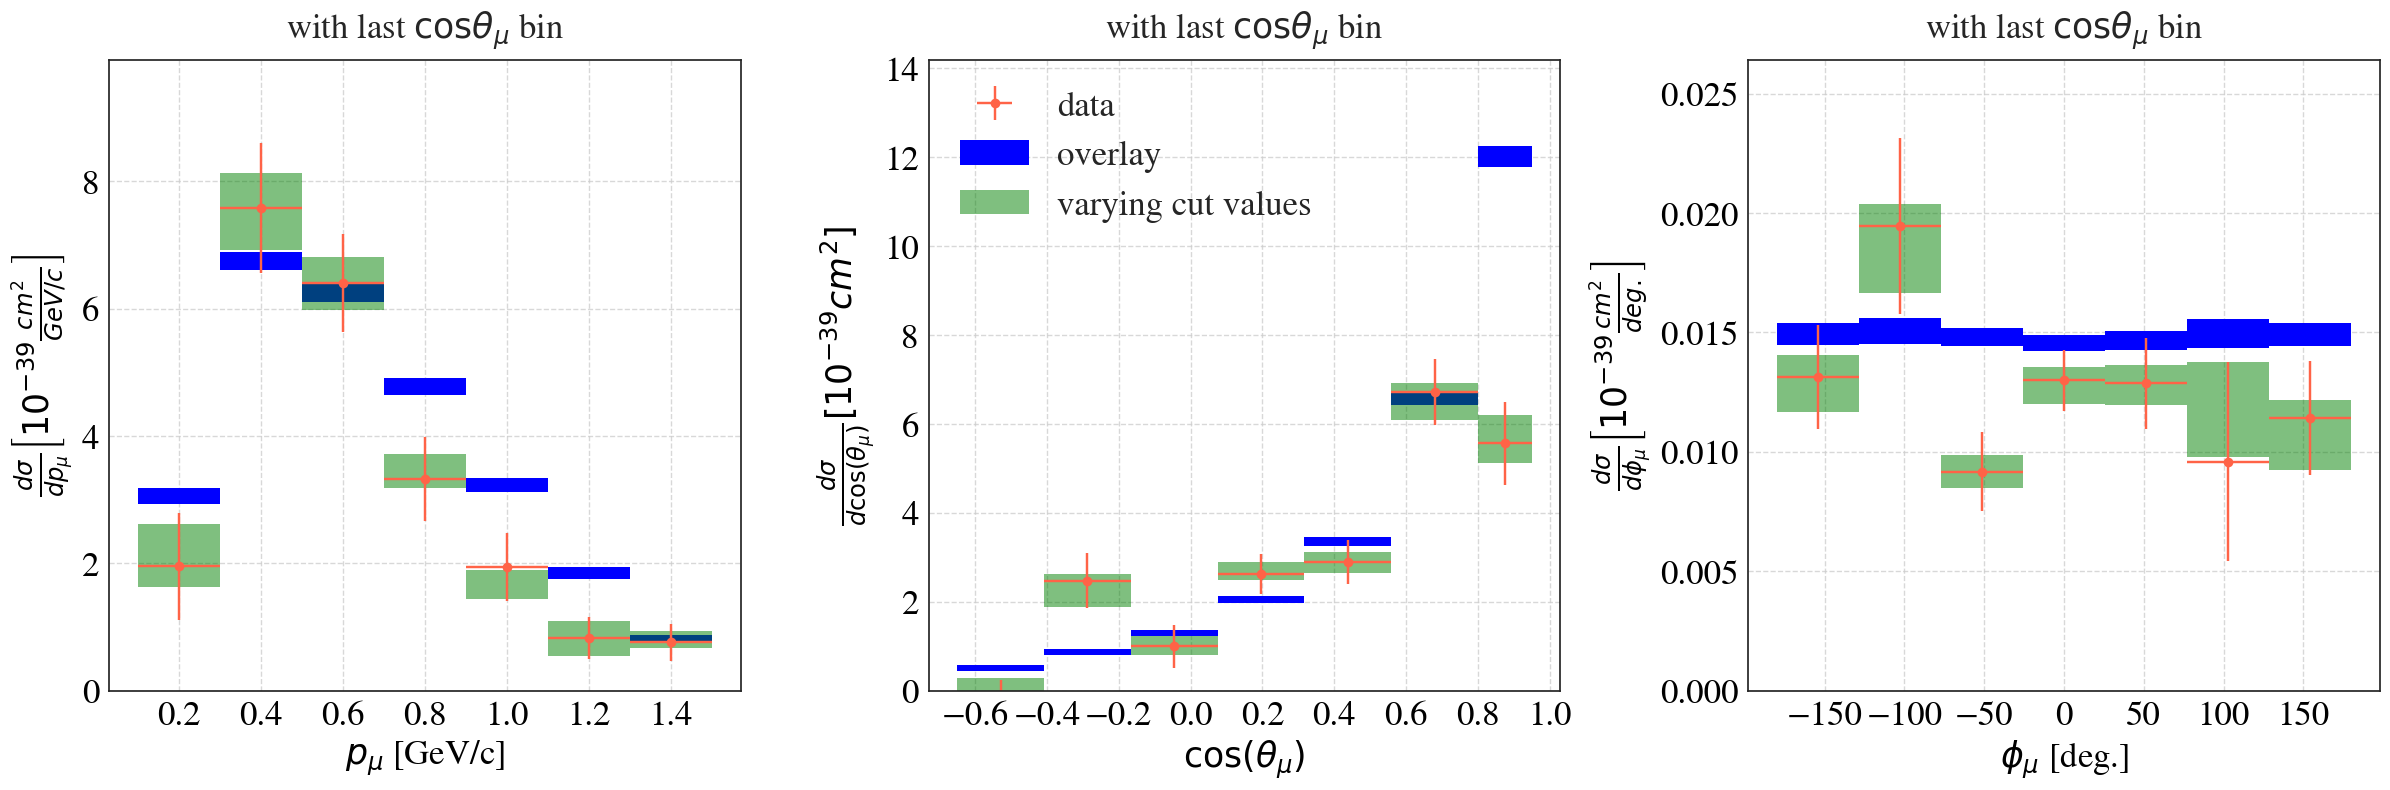

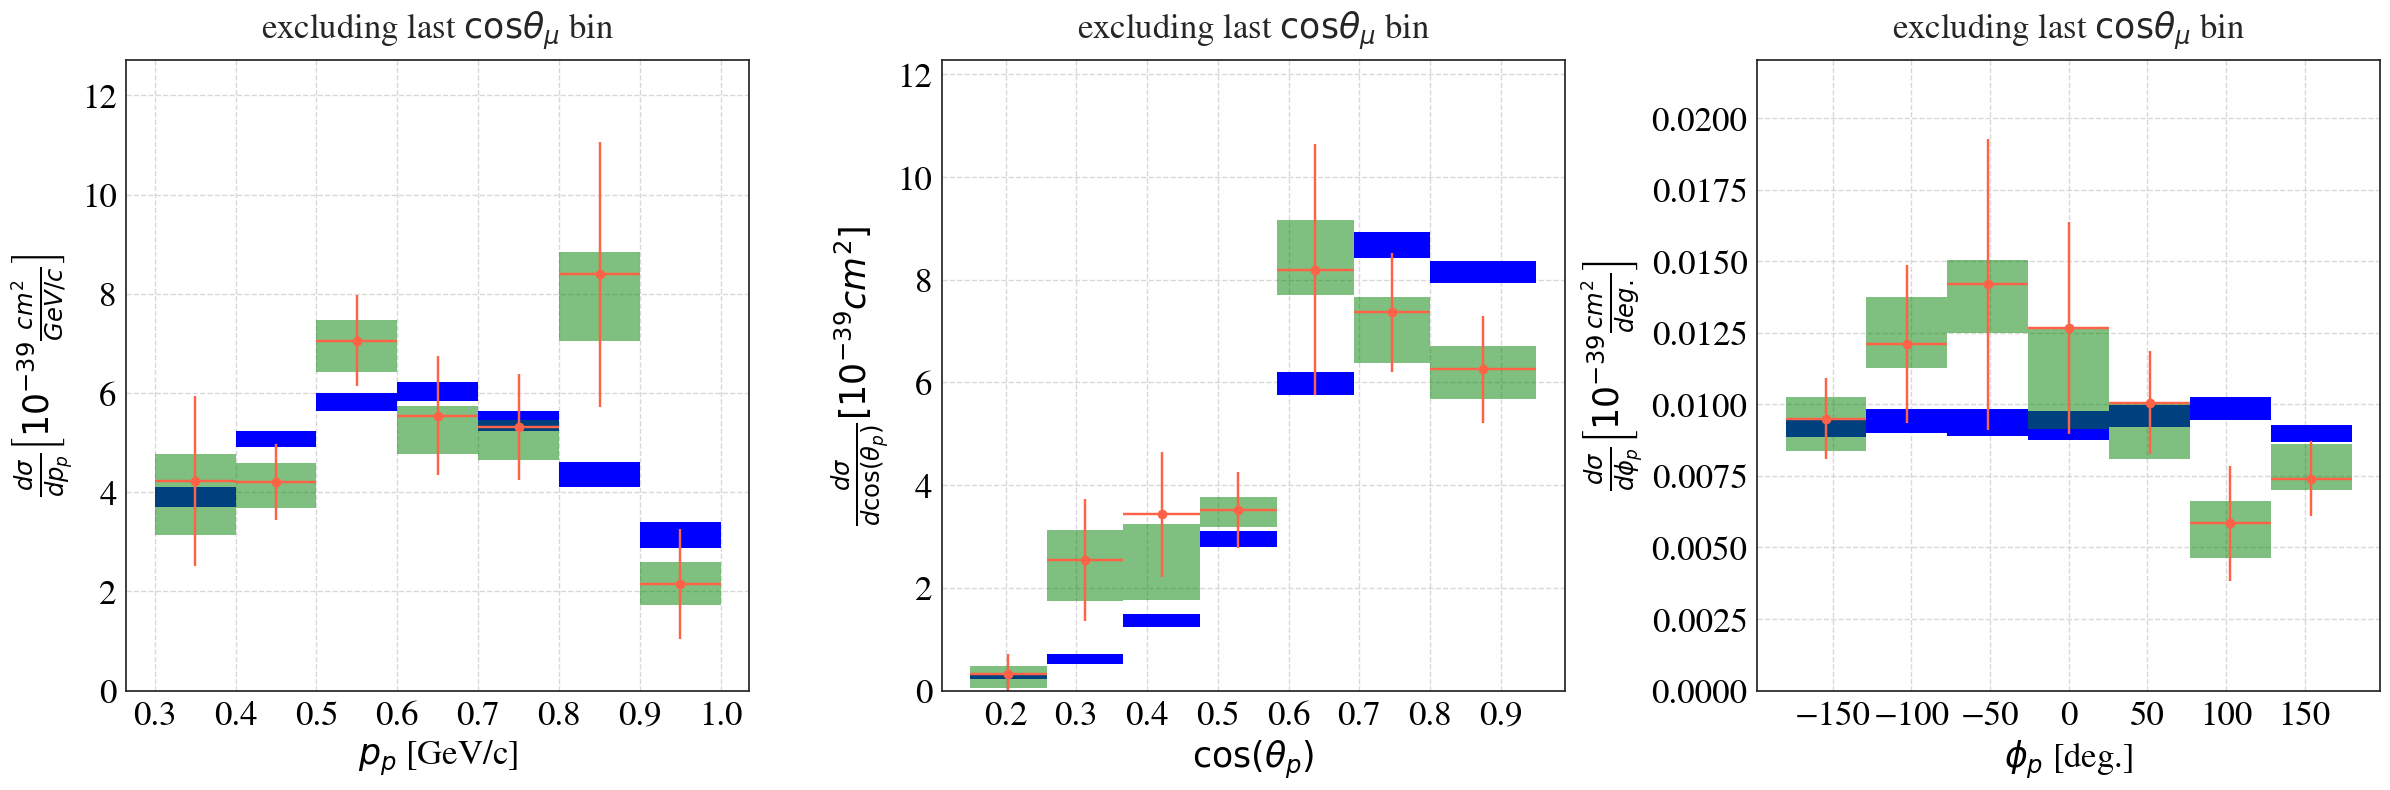

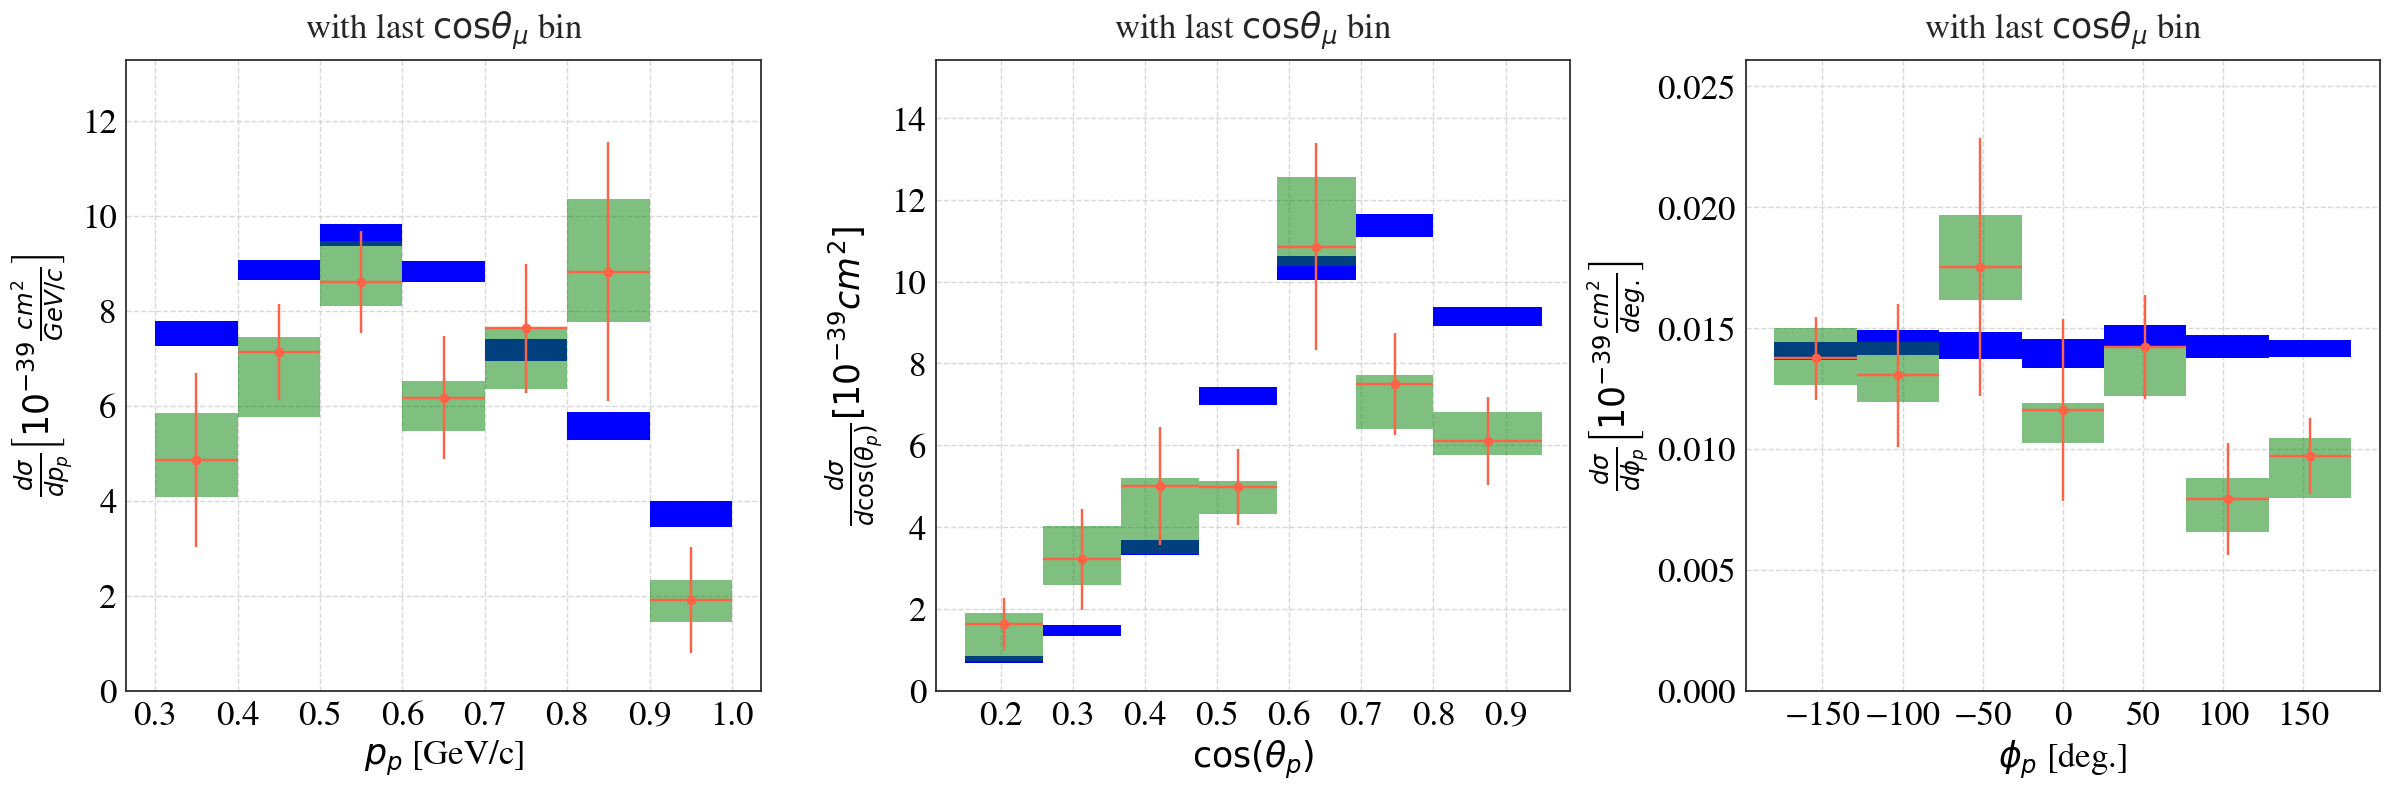

In [58]:
do_last_ctu_bin = True
for particle in ['mu','p']:
    with open(Paths['1d Xsec'] + "P" +particle + "Xsecs_1D.txt", 'rb') as infile:#{
        nominal_Xsec_dicts = pickle.load(infile)
    #}
    for iXsec,(Xsec_title,Xsec_fname,do_draw_Xsecs) in enumerate(zip(Xsec_titles,Xsec_fnames,[True,do_last_ctu_bin])):#{
        if do_draw_Xsecs==False: continue
        fig=plt.figure(figsize=(24,8))            
        Xsec_dict = nominal_Xsec_dicts[Xsec_title]
        for i,observable in enumerate(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']):#{
            var,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            h = dict()
            h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']
            h['mc Xsec'],h['mc Xsec err'] = Xsec_dict['mc '+observable], Xsec_dict['mc '+observable+' err']
            ax = fig.add_subplot(1,3,i+1)
            if iXsec==0 and var=='reco_Pmu_cos_theta':
                mid=mid[:-1]; bin_width=bin_width[:-1]; bins=bins[:-1]
                h['Xsec']=h['Xsec'][:-1];h['Xsec err']=h['Xsec err'][:-1]
                h['mc Xsec']=h['mc Xsec'][:-1];h['mc Xsec err']=h['mc Xsec err'][:-1]

            plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',label='data')
            ax.bar( x=mid , height=2*h['mc Xsec err'], bottom=h['mc Xsec']-h['mc Xsec err'], width=bin_width, color=Colors['CC1p'],label='overlay') 

            varying_Xsec_avg = np.array(mean_varying_Xsec[particle][Xsec_title][var].values())
            varying_Xsec_std = np.array(std_varying_Xsec[particle][Xsec_title][var].values())
            ax.bar( x=mid , height=2*varying_Xsec_std, bottom=varying_Xsec_avg-varying_Xsec_std, width=bin_width, color='green',label='varying cut values',alpha=0.5)
            set_axes(ax,xlabel,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$' 
                                            +(r'$\left[10^{-39} \frac{cm^{2}}{%s}\right]$'%units if units is not None 
                                              else r'$\left[10^{-39}cm^{2}\right]$'))
                             ,do_add_grid=True,do_add_legend=True if 'Pmu_cos_theta' in var else False
                             ,ylim=(0,1.1*np.max(ax.get_ylim())))
            plt.title(Xsec_title, y=1.02,fontsize=25)
        plt.tight_layout(h_pad=0)
        save_figure(figures_path + 'cut_sensitivty_'+particle+'_'+Xsec_fname+'.pdf')

In [85]:
Xsec_sys_unc = dict()
for particle in ['mu','p']:
    with open(Paths['1d Xsec'] + "P" +particle + "Xsecs_1D.txt", 'rb') as infile: nominal_Xsec_dicts = pickle.load(infile)
    for iXsec,(Xsec_title,Xsec_fname) in enumerate(zip(Xsec_titles,Xsec_fnames)):#{
        Xsec_dict = nominal_Xsec_dicts[Xsec_title]
        for i,observable in enumerate(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']
                                     ):#{
            var,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            h = dict()
            h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']
            h['mc Xsec'],h['mc Xsec err'] = Xsec_dict['mc '+observable], Xsec_dict['mc '+observable+' err']
            if iXsec==0 and var=='reco_Pmu_cos_theta':
                mid=mid[:-1]; bin_width=bin_width[:-1]; bins=bins[:-1]
                h['Xsec']=h['Xsec'][:-1];h['Xsec err']=h['Xsec err'][:-1]
                h['mc Xsec']=h['mc Xsec'][:-1];h['mc Xsec err']=h['mc Xsec err'][:-1]
                
            varying_Xsec_avg = np.array(mean_varying_Xsec[particle][Xsec_title][var].values())
            varying_Xsec_std = np.array(std_varying_Xsec[particle][Xsec_title][var].values())            
            Xsec_sys_unc[var + Xsec_fname + ' Xsec sys. err up'] = (varying_Xsec_avg + varying_Xsec_std) - h['Xsec']
            Xsec_sys_unc[var + Xsec_fname + ' Xsec sys. err dw'] = h['Xsec'] - (varying_Xsec_avg - varying_Xsec_std )

In [87]:
outfilename = Paths['systematics'] + "cut_sensitivty_systemaitcal_uncertainty.txt"
with open(outfilename, 'w') as outfile:
    outfile.write(pickle.dumps(Xsec_sys_unc))
print 'saved',outfilename

saved /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/systematics/cut_sensitivty_systemaitcal_uncertainty.txt


In [88]:
with open(Paths['systematics'] + "cut_sensitivty_systemaitcal_uncertainty.txt", 'rb') as infile: 
    Xsec_sys_unc = pickle.load(infile)
Xsec_sys_unc

{'reco_Pmu_cos_thetawith_last_ctu_bin Xsec sys. err dw': array([-0.01531144,  0.59601048,  0.18691286,  0.14536301,  0.25545507,
         0.63460679,  0.43094438]),
 'reco_Pmu_cos_thetawith_last_ctu_bin Xsec sys. err up': array([ 0.57374972,  0.14342509,  0.23546513,  0.28081268,  0.21419499,
         0.21308397,  0.64026357]),
 'reco_Pmu_cos_thetawithout_last_ctu_bin Xsec sys. err dw': array([-0.01531144,  0.59601048,  0.18691286,  0.14536301,  0.25545507,
         0.63460679]),
 'reco_Pmu_cos_thetawithout_last_ctu_bin Xsec sys. err up': array([ 0.57374972,  0.14342509,  0.23546513,  0.28081268,  0.21419499,
         0.21308397]),
 'reco_Pmu_mcs_phiwith_last_ctu_bin Xsec sys. err dw': array([ 0.00145462,  0.00281384,  0.00070453,  0.0010043 ,  0.00090906,
        -0.0002167 ,  0.00220277]),
 'reco_Pmu_mcs_phiwith_last_ctu_bin Xsec sys. err up': array([ 0.0009227 ,  0.00093677,  0.00070658,  0.0005499 ,  0.00078019,
         0.00417301,  0.00074992]),
 'reco_Pmu_mcs_phiwithout_last_ctu

In [4]:
versions['Overlay']='prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['beam on']='prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off']='prod_reco_optfilter_extbnb_v12_mcc8_dev'
versions['overlay date']='2018_09_22'
versions['data date']='2018_08_16'

extra_name=''
minPEcut = 150
maxdYZcut = 200
delta_theta_12 = 55
r_max_RdQ_CC1p = 0.43
delta_Delta_phi = 35
Pt_max = 0.35
Chi2Proton_muCandidate_min = 80
Chi2Proton_pCandidate_max = 30

samples = load_mc_and_data(extra_name=''
                     ,minPEcut = minPEcut,maxdYZcut = maxdYZcut
                     ,delta_theta_12 = delta_theta_12,r_max_RdQ_CC1p = r_max_RdQ_CC1p
                     ,delta_Delta_phi = delta_Delta_phi,Pt_max = Pt_max
                     ,Chi2Proton_muCandidate_min = Chi2Proton_muCandidate_min,Chi2Proton_pCandidate_max = Chi2Proton_pCandidate_max)
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = samples

did not find selected_cosmic.csv, so creating it...
285038 ccqe candidate pairs, 180092 in FV
74392 are 1mu-1p, 41.3%
55230 are other-pairs, 30.7%
155416 are cosmic, 86.3%
--------------------------------------------------------------
37228 are CC1p, 20.7%
I finished loading overlay samples. We have in total 285038 pairs
applied cuts to overlay
saved selected 1mu-1p to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_1mu-1p.csv
saved selected other-pairs to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_other-pairs.csv
saved selected cosmic to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_cosmic.csv
saved selected CC1p to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018

## apply the efficiency weights - if they were not computed yet

In [7]:
compute_eff_weights(beam_on=selected_beam_on,beam_off=selected_beam_off,
                        generated_CC1p=genie_CC1p,selected_CC1p=selected_CC1p,overlay=selected_overlay_concat,
                        delta_theta_12=delta_theta_12,
                        delta_Delta_phi=delta_Delta_phi,
                        Pt_max=Pt_max)     
compute_eff_weights(beam_on=selected_beam_on,beam_off=selected_beam_off,
                        generated_CC1p=genie_CC1p,selected_CC1p=selected_CC1p,overlay=selected_overlay_concat,
                        delta_theta_12=delta_theta_12,
                        delta_Delta_phi=delta_Delta_phi,
                        Pt_max=Pt_max,
                        ob_1='Pp',ob_2='cos(theta(p))',ob_3='phi(p)',
                        reco_1='reco_Pp',reco_2='reco_Pp_cos_theta',reco_3='reco_Pp_phi',
                        true_1='truth_Pp',true_2='truth_Pp_cos_theta',true_3='truth_Pp_phi') 
save_selected_samples(selected_overlay_concat , selected_CC1p , selected_beam_on , selected_beam_off)
print 'done assiging Pmu weights and Pp weights and saving the files.'

done.
done.
saved  12127 selected overlay events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_overlay.csv
saved  9538 selected CC1p events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_CC1p.csv
saved  462 selected beam_on events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prod_reco_optfilter_bnb_v12_unblind_mcc8_2018_08_16_selected_beam_on.csv
saved  15 selected beam_off events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prod_reco_optfilter_bnb_v12_unblind_mcc8_2018_08_16_selected_beam_off.csv
done assiging Pmu weights and Pp weights and saving the files.


## apply a data-driven correction for $\phi~0$

In [13]:
# iterative process for correction
for sam in [selected_beam_on,selected_beam_off,selected_CC1p,selected_overlay_concat]:
    sam['W(corr. phi~0)'] = 1
Xsec_dict = get_phi_Xsecs( do_corr_phi_0=False , debug=0 )
correction, correction_arrays = dict(),dict()
correction_arrays['mu'] = []; correction_arrays['p'] = []; step=[]
correction['mu'] = correction['p'] = 1
current_correction = 10
i = 1
while np.abs(current_correction-1)>0.0001:
    step.append(i)
    for particle,var in zip(['mu','p'],
                            ['reco_Pmu_mcs_phi','reco_Pp_phi']):
        Xsec,Xsec_err = Xsec_dict['phi('+particle+')'],Xsec_dict['phi('+particle+') err']
        bins = Bins['phi('+particle+')']
        N = len(bins)-1; n = N/2
        Xsec_phi_0 = Xsec[n]
        Xsec_phi_not_0 = np.concatenate([Xsec[:n-1],Xsec[n+1:]])
        Xsec_err_phi_not_0 = np.concatenate([Xsec_err[:n-1],Xsec_err[n+1:]])
        mean_phi_not_0 = np.average(Xsec_phi_not_0 , weights=1./np.square(Xsec_err_phi_not_0))
        current_correction = mean_phi_not_0/Xsec_phi_0
        correction[particle] = correction[particle]*current_correction
        correction_arrays[particle].append( correction[particle] )
        print 'correction for phi('+particle+')~0:',current_correction
        for sam in [selected_beam_on,selected_beam_off,selected_CC1p,selected_overlay_concat]:
            indices_phi_0 = sam.index[(bins[n] <= 180./np.pi*sam[var]) & (180./np.pi*sam[var] < bins[n+1])].tolist()
            sam.loc[indices_phi_0,'W(corr. phi~0)'] = sam.loc[indices_phi_0,'W(corr. phi~0)'] * current_correction
        Xsec_dict = get_phi_Xsecs( do_corr_phi_0=True , debug=0 )
        print 'corrected samples for ',particle,', computing Xsec'
    i = i+1
print 'done performing iterative correction for phi~0'; print
save_selected_samples(selected_overlay_concat , selected_CC1p , selected_beam_on , selected_beam_off)
print; print 'saved the samples...'

correction for phi(mu)~0: 3.03583942037
corrected samples for  mu , computing Xsec
correction for phi(p)~0: 1.4395562346
corrected samples for  p , computing Xsec
correction for phi(mu)~0: 1.04933462848
corrected samples for  mu , computing Xsec
correction for phi(p)~0: 1.0145604472
corrected samples for  p , computing Xsec
correction for phi(mu)~0: 1.00224195433
corrected samples for  mu , computing Xsec
correction for phi(p)~0: 1.00068436169
corrected samples for  p , computing Xsec
correction for phi(mu)~0: 1.00010667019
corrected samples for  mu , computing Xsec
correction for phi(p)~0: 1.000032612
corrected samples for  p , computing Xsec
done performing iterative correction for phi~0
saved  12127 selected overlay events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_overlay.csv
saved  9538 selected CC1p events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_n

## Extract (and draw) the cross-sections

In [127]:
extract_Xsecs(debug=0,extra_name=extra_name)

saved cross-sections into /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/1d_Xsec/Xsecs_1D.txt


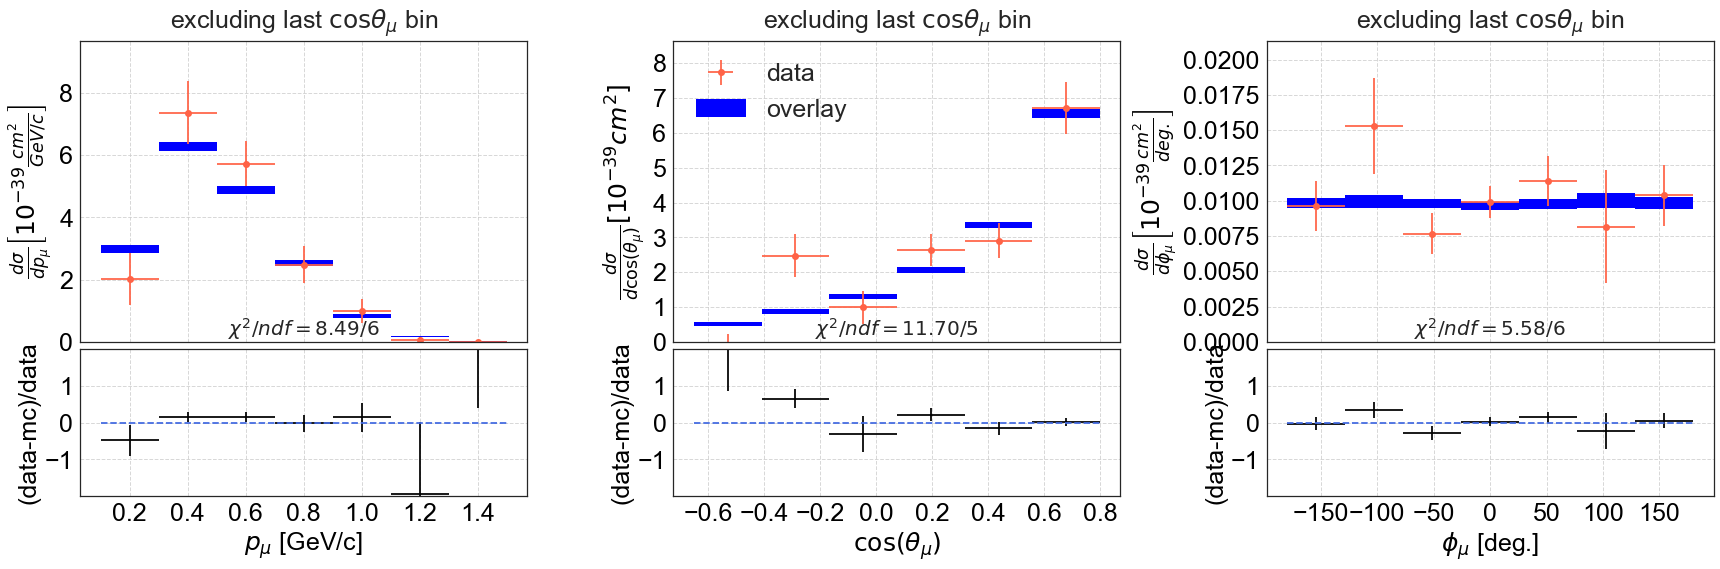

In [125]:
Draw_Xsecs(particle='mu',debug=0)